In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# %cd gdrive/MyDrive/
# ! git clone https://github.com/TimofeevAlex/LastFM.git

/content/gdrive/MyDrive/LastFM


In [1]:
import os
import sys
from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import model_to_dot

from IPython.display import clear_output

sys.path.append('src')
from train_test import train_test_split
from models import create_ncf_model
from ncf_helpers import create_train_step, create_test_step, create_inference, get_ratings
from metrics import precision_recall_at_k
# from metrics import

%load_ext autoreload
%autoreload 2

seed=0
np.random.seed(seed)

In [8]:
train = pd.read_csv('lastfm-dataset-360K/train.csv')
valid = pd.read_csv('lastfm-dataset-360K/valid.csv')
test = pd.read_csv('lastfm-dataset-360K/test.csv')
lastfm_360_behav = pd.read_csv('lastfm-dataset-360K/behav-360k-processed.csv')
lastfm_360_demo = pd.read_csv('lastfm-dataset-360K/demo-360k-processed.csv')
lastfm_360_demo = lastfm_360_demo.set_index('user_email').astype(bool)
test_users = np.load('lastfm-dataset-360K/test_users.npy')

In [3]:
train_plays_max = train['log_plays'].max()
train['log_plays'] = train['log_plays'] / train_plays_max
valid['log_plays'] = valid['log_plays'] / train_plays_max
test['log_plays'] = test['log_plays'] / train_plays_max

In [4]:
artists = lastfm_360_behav['artist_id'].unique()

In [5]:
num_artists = artists.shape[0] 
num_user_features = lastfm_360_demo.shape[1] 
num_factors = 120
batch_size = 2 ** 16
k=10

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train)
train_dataset = train_dataset.batch(batch_size)
valid_dataset = tf.data.Dataset.from_tensor_slices(valid)
valid_dataset = valid_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test)#test.append(valid)
test_dataset = test_dataset.batch(batch_size)

In [7]:
model = create_ncf_model(num_factors, num_user_features, num_artists)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)#
loss_fn = tf.keras.losses.MeanSquaredError()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=False, dpi=300)
plt.savefig('nlf_model_vertical.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_rmse = tf.keras.metrics.RootMeanSquaredError()
test_loss_avg = tf.keras.metrics.Mean()
test_rmse = tf.keras.metrics.RootMeanSquaredError()

In [ ]:
train_step = create_train_step(model, loss_fn, epoch_loss_avg, epoch_rmse)
test_step = create_test_step(model, loss_fn, test_loss_avg, test_rmse)

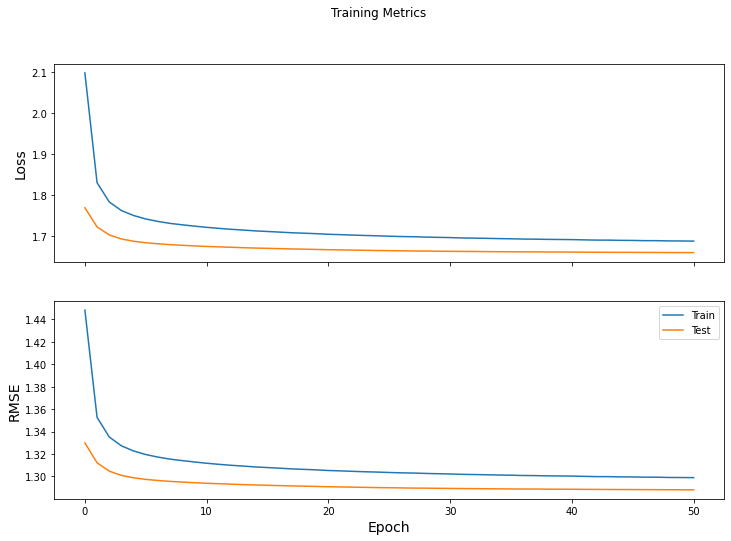

In [ ]:
num_epochs = 51
log_frequency = 1

train_loss_results = []
train_rmse_results = []
test_loss_results = []
test_rmse_results = []

timenow = str(datetime.now())
try:
    os.mkdir('saved_model/' + timenow)  
except OSError as error:  
    print(error)

try:
    os.mkdir('plots')  
except OSError as error:  
    print(error)
    
for epoch in range(num_epochs):
    epoch_loss_avg.reset_states()
    epoch_rmse.reset_states()
    for batch in train_dataset:
        user_feats = lastfm_360_demo.loc[batch[:, 0]]
        artist_id = batch[:, 1]
        y = batch[:, 2]
        loss_value = train_step([user_feats, artist_id], y) 

    train_loss_results.append(epoch_loss_avg.result().numpy())
    train_rmse_results.append(epoch_rmse.result().numpy())

    if epoch % log_frequency == 0:
        model.save('saved_model/' + timenow + '/model_' + str(epoch))
        # Validation
        test_loss_avg.reset_states()
        test_rmse.reset_states()
        for batch in valid_dataset:
            user_feats = lastfm_360_demo.loc[batch[:, 0]]
            artist_id = batch[:, 1]
            y = batch[:, 2]
            loss_value = test_step([user_feats, artist_id], y)
        test_loss_results.append(test_loss_avg.result().numpy())
        test_rmse_results.append(tf.sqrt(test_loss_avg.result().numpy()))

        # Plot metrics  
        clear_output(wait=True)
        fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
        fig.suptitle('Training Metrics')

        axes[0].set_ylabel("Loss", fontsize=14)
        axes[0].plot(train_loss_results, label='Train')
        axes[0].plot(np.arange(0, epoch+1, log_frequency), test_loss_results, label='Test')

        axes[1].set_ylabel("RMSE", fontsize=14)
        axes[1].set_xlabel("Epoch", fontsize=14)
        axes[1].plot(train_rmse_results, label='Train')
        axes[1].plot(np.arange(0, epoch+1, log_frequency), test_rmse_results, label='Test')
        plt.legend()
        plt.savefig('plots/metrics_'+ timenow +'.png')
        plt.show()
        #plot gradients

### Test

In [19]:
inference = create_inference(model)
seen_artists = train.append(valid).drop(columns='log_plays')
seen_artists = seen_artists[seen_artists['user_email'].isin(test_users)]
pred_ratings = get_ratings(inference, seen_artists, lastfm_360_demo, artists)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<15:32,  1.07it/s]

  0%|          | 2/1000 [00:01<14:35,  1.14it/s]

100%|██████████| 1000/1000 [14:36<00:00,  1.14it/s]


In [41]:
precisions, recalls = precision_recall_at_k(test[test['user_email'].isin(test_users)], pred_ratings)

In [42]:
print(np.mean(precisions), np.mean(recalls))

0.0 0.0


In [47]:
lastfm_360_behav.shape

(17309231, 5)